<a href="https://colab.research.google.com/github/saranya2816-sudo/HOUSE-PRICE-PREDICTION/blob/main/house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
# xgboost install: pip install xgboost
from xgboost import XGBRegressor

# optional for plotting EDA & SHAP
import matplotlib.pyplot as plt
import seaborn as sns
import shap


Loading Data


In [ ]:
df = pd.read_csv("train.csv")   # replace with your path
# target often named 'SalePrice' in Kaggle dataset
y = df['SalePrice']
X = df.drop(columns=['SalePrice'])


Exploring the data

In [ ]:
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<Axes: >

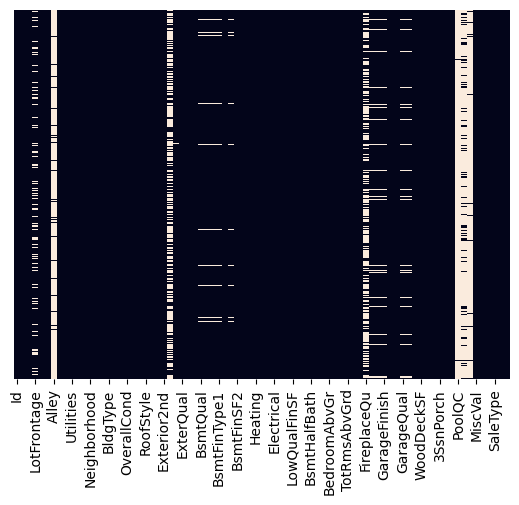

In [ ]:
# heatmap for visualizing the null vaues
sns.heatmap(df.isnull(),yticklabels = False,cbar = False)

EDA

In [ ]:
# identify columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # scaling optional for tree models but safe
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


Preprocessing

In [ ]:
# identify columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # scaling optional for tree models but safe
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


Understanding the correlation between various features in the dataset

1.Positive Correlation
2.Negative Correlation

In [ ]:
correlation = house.select_dtypes(include=['number']).corr()


<Axes: >

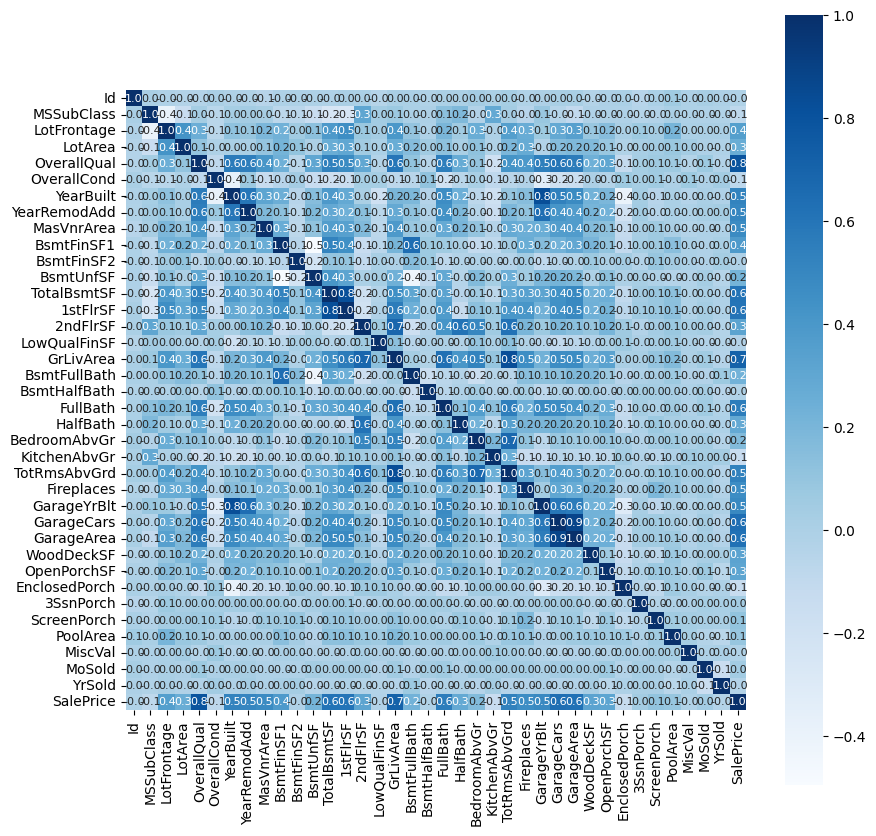

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
house = pd.read_csv("train.csv")

# Compute correlation only for numeric columns
correlation = house.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

Baseline model

In [ ]:
# log-transform the target (optional)
y_log = np.log1p(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

baseline_pipe = Pipeline([
    ('pre', preprocessor),
    ('reg', LinearRegression())
])
baseline_pipe.fit(X_train, y_train)

preds_log = baseline_pipe.predict(X_valid)
preds = np.expm1(preds_log)          # back to original dollars
y_valid_orig = np.expm1(y_valid)

rmse = np.sqrt(mean_squared_error(y_valid_orig, preds))
mae = mean_absolute_error(y_valid_orig, preds)
r2 = r2_score(y_valid_orig, preds)
print("Baseline RMSE:", rmse, " MAE:", mae, " R2:", r2)


Baseline RMSE: 22745.151851558345  MAE: 14894.6237919441  R2: 0.9325528121260741


Feature Engineering

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select only numeric columns
numeric_data = house.select_dtypes(include=['number'])

# Scale the numeric data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(numeric_data)

# Convert back to a DataFrame for easier use
df_scaled = pd.DataFrame(df_scaled, columns=numeric_data.columns)


Model selection

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


train and Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split features (X) and target (y)
X = house.drop('SalePrice', axis=1)
y = house['SalePrice']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(1460, 80) (1168, 80) (292, 80)


Model Training

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#  preprocessor (adjust columns as per your dataset)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['num_col1', 'num_col2', 'num_col3']),   # numeric columns
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['cat_col1', 'cat_col2'])  # categorical columns
])


In [ ]:
import pandas as pd

df = pd.read_csv("train.csv")  # replace with your file
X = df.drop("SalePrice", axis=1)  # features
y = df["SalePrice"]               # target variable
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding all categorical columns

# Convert categorical columns to numeric
X = pd.get_dummies(X, drop_first=True)

# Fill missing values with median (for numeric columns)
X = X.fillna(X.median())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression RMSE: 49289.186669387775


Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))


Random Forest RMSE: 29019.18277425443
Random Forest R2 Score: 0.8902115834269836


Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Root Mean Squared Error (RMSE): 82993.5131924118
R-squared (R2): 0.10200387233009434


Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of trees
    'max_depth': [None, 10, 20, 30],        # Maximum depth of tree
    'min_samples_split': [2, 5, 10],        # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples at leaf node
    'max_features': ['auto', 'sqrt']        # Features considered at each split
}


In [ ]:
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=20,       # number of random combinations
                                   cv=5,
                                   n_jobs=-1,
                                   scoring='r2',
                                   verbose=2,
                                   random_state=42)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_rf_random = random_search.best_estimator_
y_pred_random = best_rf_random.predict(X_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


In [ ]:
#Evaluate tuning Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the tuned Random Forest model
rf_best = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rf_best.fit(X_train, y_train)

# Predict on test set
y_pred_best = rf_best.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("Tuned Random Forest RMSE:", rmse)
print("Tuned Random Forest R2 Score:", r2)



Tuned Random Forest RMSE: 29312.01098795342
Tuned Random Forest R2 Score: 0.88798468735882


Save the Model

In [ ]:
import joblib
from sklearn.ensemble import RandomForestRegressor

best_rf = RandomForestRegressor(
    n_estimators=200,  # example tuned parameter
    max_depth=10,      # example tuned parameter
    random_state=42
)

# Train the model if not already trained
best_rf.fit(X_train, y_train)

# Save the trained model
joblib.dump(best_rf, "house.pkl")
print("Model saved successfully as 'house.pkl'")


Model saved successfully as 'house.pkl'


In [ ]:
# Load the model
loaded_model = joblib.load("house.pkl")

# Make predictions with the loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Optional: Evaluate loaded model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred_loaded))
r2 = r2_score(y_test, y_pred_loaded)

print("Loaded Model RMSE:", rmse)
print("Loaded Model R2 Score:", r2)


Loaded Model RMSE: 29312.01098795342
Loaded Model R2 Score: 0.88798468735882


Prediction and Deployment

In [ ]:
# Predict house prices on test data (or new unseen data)
y_pred = loaded_model.predict(X_test)

# Optional: View first 10 predictions vs actual
for actual, pred in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual}, Predicted: {pred:.2f}")


Actual: 154500, Predicted: 139457.12
Actual: 325000, Predicted: 317799.66
Actual: 115000, Predicted: 118785.96
Actual: 159000, Predicted: 152767.65
Actual: 315500, Predicted: 323488.40
Actual: 75500, Predicted: 86175.26
Actual: 311500, Predicted: 210526.48
Actual: 146000, Predicted: 154852.16
Actual: 84500, Predicted: 85934.24
Actual: 135500, Predicted: 129953.53


Visualize Predictions

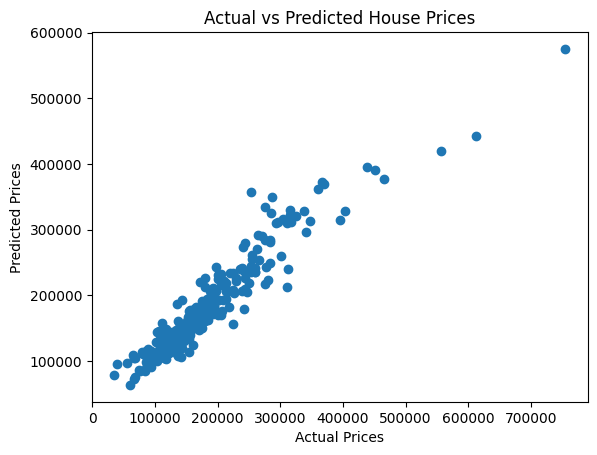

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, y_pred_rf)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()


In [ ]:
import os
print(os.getcwd())   # Shows current working directory
print(os.listdir())  # Lists all files in it


/content
['.config', 'train.csv', 'test.csv', 'sample_data']


In [ ]:

from sklearn.ensemble import RandomForestRegressor
import joblib

#  Step 1: Create sample dataset
data = {
    'OverallQual': [5, 7, 6, 8, 9, 4, 3],
    'GrLivArea': [1500, 2000, 1800, 2400, 3000, 1200, 900],
    'GarageCars': [2, 2, 2, 3, 3, 1, 1],
    'TotalBsmtSF': [800, 1000, 950, 1200, 1300, 700, 600],
    'SalePrice': [200000, 250000, 230000, 310000, 360000, 170000, 140000]
}
df = pd.DataFrame(data)

#  Step 2: Split features & target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

#  Step 3: Train model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

#  Step 4: Save model
joblib.dump(model, "house.pkl")
print("house.pkl file created successfully!")


house.pkl file created successfully!


In [ ]:
loaded_model = joblib.load("house.pkl")


final Result:

In [ ]:
import pandas as pd
import joblib

#  Load model
loaded_model = joblib.load("house.pkl")

#  Define features (must match training features)
model_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']

#  Create empty DataFrame with those features
input_data = pd.DataFrame(columns=model_features)

# Get user input
input_data.loc[0, 'OverallQual'] = int(input("Overall Quality (1-10): "))
input_data.loc[0, 'GrLivArea'] = float(input("Above Ground Living Area (sq ft): "))
input_data.loc[0, 'GarageCars'] = int(input("Number of Garage Cars: "))
input_data.loc[0, 'TotalBsmtSF'] = float(input("Total Basement Area (sq ft): "))

#  Fill missing features (if any)
input_data = input_data.fillna(0)

# Predict price
predicted_price = loaded_model.predict(input_data)[0]
print(f"\n🏠 Predicted House Price: ${predicted_price:,.2f}")

